In [15]:
import geopandas as gpd
from shapely.ops import unary_union
from shapely import LineString, Polygon, simplify, MultiPoint, Point
from math import sqrt, pow
from utils import *

In [2]:
geojson_file = './data/ni.json'
gdf = gpd.read_file(geojson_file)

# Convert from raw geojson to shapely polygon with no islands or internal borders

# Extract Shapely objects from GDF to shapes array
polygons = []
for i in range(gdf.shape[0]):
    polygons.append(gdf.iloc[i]['geometry'])
# plot_map(polygons)

# Remove Islands
no_islands = remove_islands(polygons)
# plot_map(no_islands)

# Remove internal borders
unified_areas = unary_union(no_islands)
unified_ext_coords = unified_areas.exterior.coords
border_polygon = Polygon(unified_ext_coords)
simple_polygon = simplify(border_polygon, tolerance=0.01) # Douglas Peucker Algorithm

In [ ]:
def calculate_slope(p1, p2):
    if p2[0] == p1[0]:
        return float('inf')
    return (p2[1] - p1[1]) / (p2[0]-p1[0])

# returns angle bisector slope - perpendicular is the other bisector
def find_bisector_slope(e1, e2):

    a1 = calculate_slope(e1[0], e1[1])
    a2 = calculate_slope(e2[0], e2[1])

    print(a1, a2)

    b1, b2 = -1, -1

    s1 = sqrt(a1**2+1)
    s2 = sqrt(a2**2+1)

    slope_ab = -1*( ((a1/s1)-(a2/s2)) / (b1/s1)-(b2/s2) )

    return slope_ab

def find_angle_bisector(e1, e2):
    
    p1, p2 = e1
    p3, p4 = e2

    # points
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4

    # Calculate slopes and intercepts for the lines, handle vertical line cases
    if x2 != x1:
        a1 = (y2 - y1) / (x2 - x1)
        c1 = y1 - a1 * x1
    else:
        # Vertical line handling
        a1 = float('inf')
        c1 = x1 

    if x4 != x3:
        a2 = (y4 - y3) / (x4 - x3)
        c2 = y3 - a2 * x3
    else:
        # Vertical line handling
        a2 = float('inf')
        c2 = x3 
    
    # Define the coefficients a, b, c for each line in the form ax + by + c = 0
    b1, b2 = -1, -1

    # angular bisector - pluses or minuses not sure
    a = (a1/sqrt(a1*a1+b1*b1))+(a2/sqrt(a2*a2+b2*b2))
    b = (b1/sqrt(a1*a1+b1*b1))+(b2/sqrt(a2*a2+b2*b2))
    c = (c1/sqrt(a1*a1+b1*b1))+(c2/sqrt(a2*a2+b2*b2))

    # Might need to convert between perpendicular lines depending on which bisector is neeed
    return (a, b, c)

# Returns the points where p1-p4 project on the opposing edge (0-4 points returned)
def get_projected_points(e1, e2):

    proj_points = []

    a, b, c = find_angle_bisector(e1, e2)

    if a == 0:
        projection_slope = float('inf')
    else:
        projection_slope = b/a # perpendicular to bisector slope

    x1, y1 = e1[0] # line segment from (x1, y1) to (x4, y4)
    x2, y2 = e1[1]

    x3, y3 = e2[0] # line segment from (x3, y3) to (x4, y4)
    x4, y4 = e2[1]

    segment_slope = (y4-y3)/(x4-x3)

    x_proj1 = (y1 - (projection_slope * x1) - (y3 - x3 * segment_slope))/(segment_slope-projection_slope)
    y_proj1 = segment_slope * x_proj1 + (y3 - x3 * segment_slope)
    x_proj2 = (y2 - (projection_slope * x2) - (y3 - x3 * segment_slope))/(segment_slope-projection_slope)
    y_proj2 = segment_slope * x_proj2 + (y3 - x3 * segment_slope)
    x_proj3 = (y3 - (projection_slope * x3) - (y1 - x1 * segment_slope))/(segment_slope-projection_slope)
    y_proj3 = segment_slope * x_proj3 + (y1 - x1 * segment_slope)
    x_proj4 = (y4 - (projection_slope * x4) - (y1 - x1 * segment_slope))/(segment_slope-projection_slope)
    y_proj4 = segment_slope * x_proj4 + (y1 - x1 * segment_slope)

    if min(x3, x4) <= x_proj1 <= max(x3, x4) and min(y3, y4) <= y_proj1 <= max(y3, y4):
        print("1")
        proj_points.append((x_proj1, y_proj1))
    
    if min(x3, x4) <= x_proj2 <= max(x3, x4) and min(y3, y4) <= y_proj2 <= max(y3, y4):
        print("2")
        proj_points.append((x_proj2, y_proj2))
    
    if min(x3, x4) <= x_proj3 <= max(x3, x4) and min(y3, y4) <= y_proj3 <= max(y3, y4):
        print("3")
        proj_points.append((x_proj3, y_proj3))
    
    if min(x3, x4) <= x_proj4 <= max(x3, x4) and min(y3, y4) <= y_proj4 <= max(y3, y4):
        print("4")
        proj_points.append((x_proj4, y_proj4))
    
    return proj_points


# def find_cut_line(cut_polygon):
    
    
    
def create_hexagon(center_x, center_y, radius):
     # Generate the six vertices of the hexagon
    points = [
        (
            center_x + radius * math.cos(math.radians(angle)),
            center_y + radius * math.sin(math.radians(angle))
        )
        for angle in range(0, 360, 90)  # 60-degree increments for each vertex
    ]
    # Create and return the hexagon polygon
    hexagon = Polygon(points)
    return hexagon

In [23]:
e1 = ((1, 2), (5, 5))
e2 = ((5, 5), (6, 4))
print(find_bisector_slope(e1, e2))

0.75 -1.0
0.926776695296637


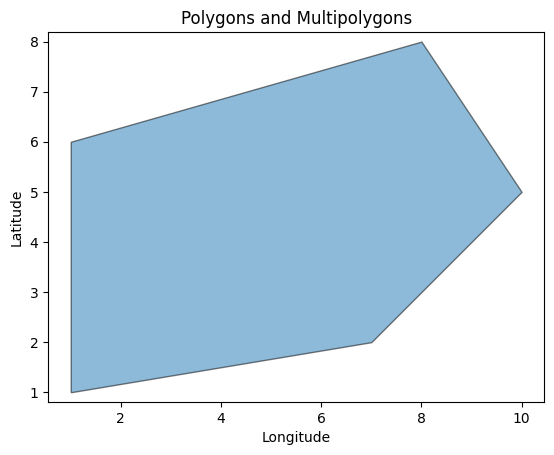

2
[<POINT (8 8)>]


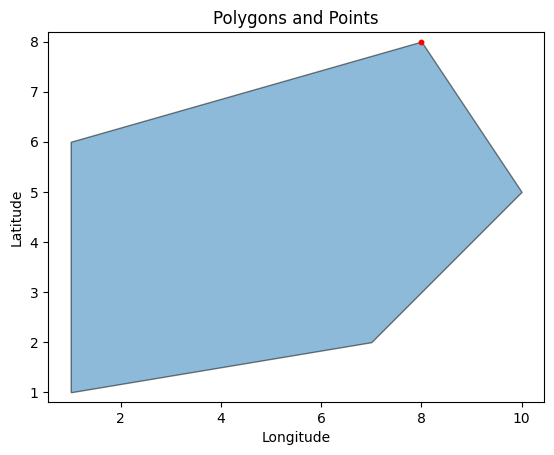

2
[<POINT (9.852 4.852)>]


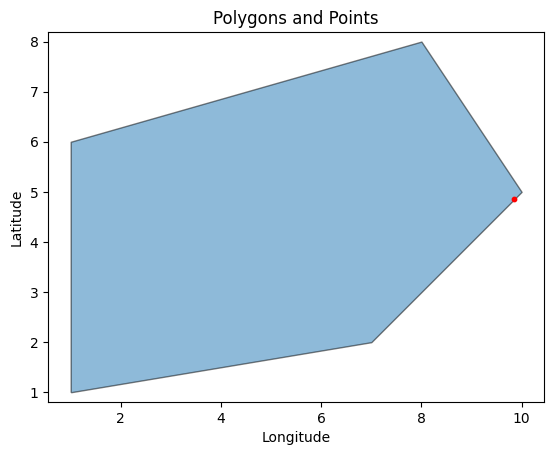

1
[<POINT (2.086 1.181)>]


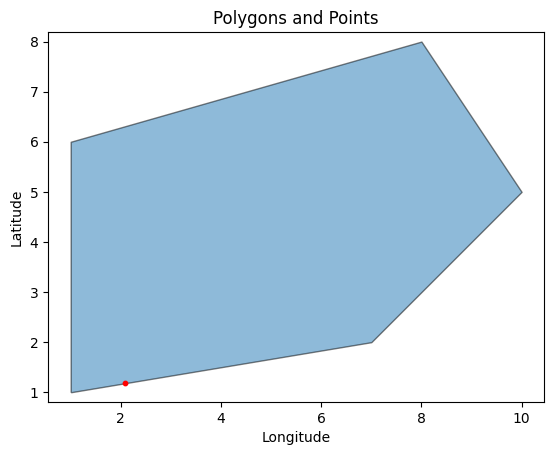

1
2
[<POINT (7.45 2.45)>, <POINT (10 5)>]


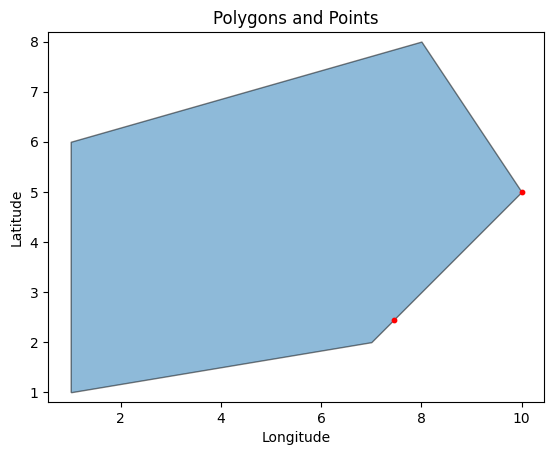

1
[<POINT (5.276 1.713)>]


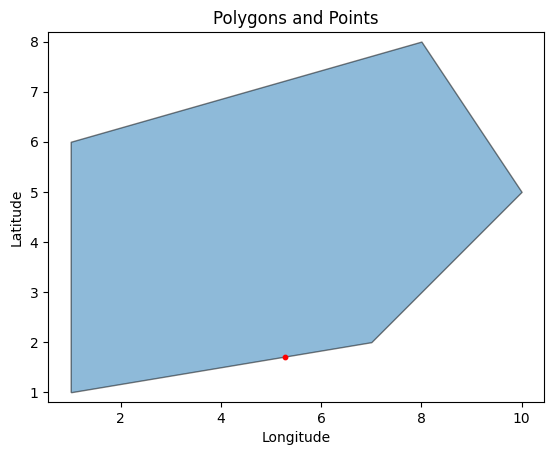

2
[<POINT (7 2)>]


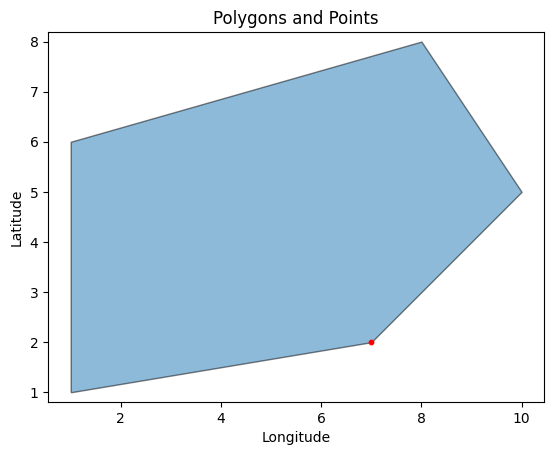

In [7]:
# https://www.khetarpal.org/polygon-splitting/

points = [(1, 1), (1, 6), (8, 8), (10, 5), (7, 2)]

square = Polygon(points)
plot_map(square)
N = 30 # Number of partitions
total_area = square.area
partition_area = total_area/30

# Each step: split remaining polygon into two parts, with sizes partition_area and remaining_area - partition_area
# select edge pair -> get angle bisector -> find projections of vertices onto other edge across the bisector ->
# form combination of triangles/trapezoid


partition_polygons = []
remaining_polygon = square
# while remaining_polygon.area > partition_area:

# Get list of edges in remaining polygon
vertices = remaining_polygon.exterior.coords
edges = list(zip(vertices[:-1], vertices[1:]))

# Try pairs of edges
for i1 in range(len(edges)):
    for i2 in range(i1+1, len(edges)):
        proj_point_coords = get_projected_points(edges[i1], edges[i2])
        if len(proj_point_coords) == 0:
            continue
        
        proj_points = []
        for point in proj_point_coords:
            proj_points.append(Point(point))
        
        print(proj_points)

        # If we reach this point, the edge pair is possible
        edge_pair_polygon_points = proj_points+[Point(edges[i1][0]), Point(edges[i1][1]), Point(edges[i2][0]), Point(edges[i2][1])]
        plot_points_and_map(proj_points, square, 40)
            
        



